In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta, datetime

# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect,distinct

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [6]:
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [8]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [9]:
# reflect an existing database into a new model

# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [10]:
# View all of the classes that automap found
for table_name in Base.classes.keys():
    print("Found table:", table_name)

Found table: measurement
Found table: station


In [11]:
# Save references to each table
tables = {}

for table_name,table_class in Base.classes.items():
    tables[table_name]=table_class

print(tables)

{'measurement': <class 'sqlalchemy.ext.automap.measurement'>, 'station': <class 'sqlalchemy.ext.automap.station'>}


In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [90]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date.date

'2017-08-23'

In [15]:
rpc_date = session.query(Measurement.date, Measurement.prcp).all()
rpc_date

[('2010-01-01', 0.08),
 ('2010-01-02', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-06', None),
 ('2010-01-07', 0.06),
 ('2010-01-08', 0.0),
 ('2010-01-09', 0.0),
 ('2010-01-10', 0.0),
 ('2010-01-11', 0.01),
 ('2010-01-12', 0.0),
 ('2010-01-14', 0.0),
 ('2010-01-15', 0.0),
 ('2010-01-16', 0.0),
 ('2010-01-17', 0.0),
 ('2010-01-18', 0.0),
 ('2010-01-19', 0.0),
 ('2010-01-20', 0.0),
 ('2010-01-21', 0.0),
 ('2010-01-22', 0.0),
 ('2010-01-23', 0.0),
 ('2010-01-24', 0.01),
 ('2010-01-25', 0.0),
 ('2010-01-26', 0.04),
 ('2010-01-27', 0.12),
 ('2010-01-28', 0.0),
 ('2010-01-30', None),
 ('2010-01-31', 0.03),
 ('2010-02-01', 0.01),
 ('2010-02-03', None),
 ('2010-02-04', 0.01),
 ('2010-02-05', 0.0),
 ('2010-02-06', 0.0),
 ('2010-02-07', 0.0),
 ('2010-02-08', 0.0),
 ('2010-02-09', 0.0),
 ('2010-02-11', 0.0),
 ('2010-02-12', 0.02),
 ('2010-02-13', 0.01),
 ('2010-02-14', 0.0),
 ('2010-02-15', 0.0),
 ('2010-02-16', 0.0),
 ('2010-02-17', 0.0),
 ('2010-02-19', None),
 ('2010-02-20', 0

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
recent_date_dt = datetime.strptime(recent_date.date, '%Y-%m-%d')
one_year_past_date = recent_date_dt - timedelta(days=365)
one_year_past_date_str = one_year_past_date.strftime('%Y-%m-%d')
recent_date_str = recent_date_dt.strftime('%Y-%m-%d')

#prpc_date = session.query(Measurement.date, Measurement.prcp).all()

# Perform a query to retrieve the data and precipitation scores
prpc_date = session.query(Measurement.date, Measurement.prcp).\
            filter((Measurement.date <= recent_date_str) & (Measurement.date >= one_year_past_date_str)).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(prpc_date, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df.sort_values('Date', ascending=True, inplace=True)
df.isnull().sum()


Date               0
Precipitation    209
dtype: int64

In [17]:
# handle NAN values
avg_pcrp = round(df['Precipitation'].mean(),0)
df['Precipitation'].fillna(avg_pcrp, inplace=True)

In [18]:
prcp_data = df.groupby(['Date']).sum().astype(float).reset_index()
prcp_data

,Date,Precipitation
0,2016-08-23,2.71
1,2016-08-24,9.33
2,2016-08-25,0.54
3,2016-08-26,0.10
4,2016-08-27,0.32
...,...,...
361,2017-08-19,0.09
362,2017-08-20,0.01
363,2017-08-21,0.58
364,2017-08-22,0.50


In [74]:
monthly_bins = pd.date_range(start=one_year_past_date_str, end=recent_date_str, freq='MS').tolist()
type(monthly_bins)

list

In [75]:
# Convert data['Date'] to a numpy array
date_array = np.array(prcp_data['Date']).tolist()
type(date_array)

list

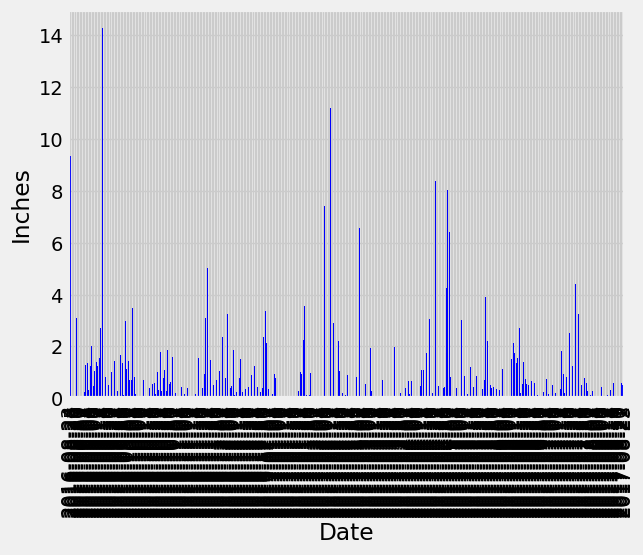

In [97]:
# Create bins with 2-month date differences
#monthly_bins = pd.date_range(start=one_year_past_date_str, end=recent_date_str, freq='MS').strftime('%b %Y').tolist()

# Convert data['Date'] to a numpy array
#date_array = np.array(prcp_data['Date']).tolist()

# Calculate the positions of monthly ticks
monthly_tick_positions = np.intersect1d(monthly_bins, date_array)


ax = prcp_data.plot(kind='bar', x='Date', y='Precipitation', color='b', legend=None)

# Set custom x-axis ticks
# Set custom x-axis ticks and labels for each month
# #plt.xticks(monthly_tick_positions, monthly_bins, rotation=45)

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
ax.set_title('')

# Show the plot
plt.show()

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_data.describe()

,Precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


# Exploratory Station Analysis

In [82]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(distinct(Measurement.station)).count()
stations

9

In [31]:
# Design a query to find the most active stations
active_stations = session.query(Measurement.station, func.count(Measurement.station)) \
                         .group_by(Measurement.station) \
                         .order_by(func.count(Measurement.station).desc()) \
                         .all()

# Print the stations and their counts in descending order
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [87]:
active_stations2 = session.query(Measurement.station, func.count(Measurement.station)) \
                         .group_by(Measurement.station) \
                         .order_by(func.count(Measurement.station).desc()) \
                         .limit(1).all()
most_active_station = active_stations2[0][0]
print(most_active_station)

USC00519281


In [88]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
result = session.query(func.min(Measurement.tobs),
                       func.max(Measurement.tobs),
                       func.avg(Measurement.tobs)) \
                .filter(Measurement.station == most_active_station) \
                .all()

# Print the results
lowest_temp, highest_temp, avg_temp = result[0]
print(f"For station USC00519281:")
print(f"Lowest Temperature: {lowest_temp} F")
print(f"Highest Temperature: {highest_temp} F")
print(f"Average Temperature: {avg_temp:.2f} F")

For station USC00519281:
Lowest Temperature: 54.0 F
Highest Temperature: 85.0 F
Average Temperature: 71.66 F


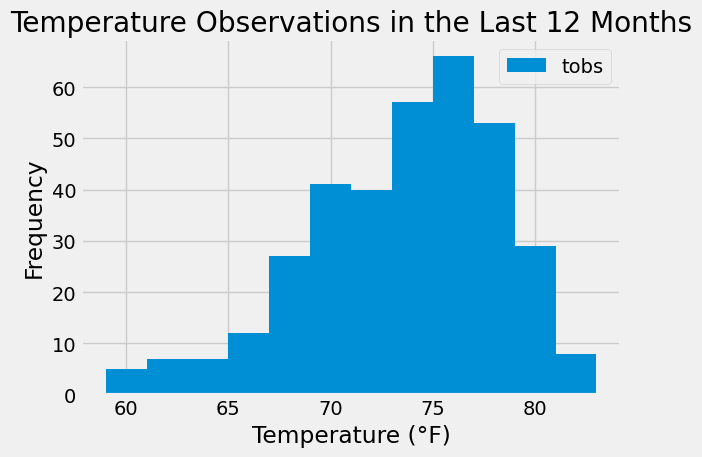

In [89]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Calculate the date one year ago from the last date in the dataset
latest_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Query the temperature observations for the most active station within the last 12 months
results = session.query(Measurement.tobs) \
                 .filter((Measurement.station == most_active_station) & \
                              (Measurement.date >= one_year_ago_str)) \
                 .all()

# Extract temperatures from the results
temperatures = [result[0] for result in results]

# Plot the results as a histogram
plt.hist(temperatures, bins=12, label='tobs')
plt.legend()
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations in the Last 12 Months')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [25]:
# Close Session
session.close()